In [1]:
#Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import math

#Análise dos dados
df = pd.read_csv('dogeusdt.csv')
Price = df["close"]
Time = list(range(len(Price)-1))
df

r=[]
R = []
rl=[]
RL = []
rn = []
RN = []


# Retorno
for i in range(len(Price)-1):
    r = ((Price[i+1] - Price[i])/Price[i])
    R.append(r)
    
# Retorno Log
for i in range(len(Price)-1):
    rl = np.log10(Price[i+1]) - np.log10(Price[i])
    RL.append(rl)
    
# Retorno Normalizado
m = np.mean(R)
s = np.std(R)
for i in range(len(Price)-1):
    rn = (R[i] - m)/(s)
    RN.append(rn)

In [2]:
# MARKOV #

In [3]:
# Definição inicial para o cálculo das
# Matrizes de Probabilidades


# Alto
PBull_Bull = 0
PBull_Crab = 0
PBull_Bear = 0

# Neutro
PCrab_Bull = 0
PCrab_Crab = 0
PCrab_Bear = 0

# Baixo
PBear_Bull = 0
PBear_Crab = 0
PBear_Bear = 0

# Margem
S = np.std(R)

Para definir as Matrizes de Probabilidade, definiremos valores em relação à Margens da seguinte forma:

Alto: $R_{t} > Margem$

Neutro: $-Margem < R_{t} < Margem$

Baixo: $R_{t} < -Margem$

In [4]:
# Cálculo da Matriz de Probabilidade#

for i in range(len(R)-1):
    # Probabilidade Alta
    if R[i]>S:
        # Alta -> Alta
        if R[i+1]>S:
            PBull_Bull += 1
        # Alta -> Neutra
        elif -S<R[i+1]<S:
            PBull_Crab += 1
        # Alta -> Baixa
        elif S<-R[i+1]:
            PBull_Bear += 1
            
    # Probabilidade Alta
    elif -S<R[i]<S:
        # Neutra -> Alta
        if R[i+1]>S:
            PCrab_Bull += 1
        # Neutra -> Neutra
        elif -S<R[i+1]<S:
            PCrab_Crab += 1
        # Neutra -> Baixa
        elif R[i+1]<-S:
            PCrab_Bear += 1
            
    # Probabilidade Baixa
    elif R[i]<-S:
        # Baixa -> Alta
        if R[i+1]>S:
            PBear_Bull += 1
        # Baixa -> Neutra
        elif -S<R[i+1]<S:
            PBear_Crab += 1
        # Baixa -> Baixa
        elif R[i+1]<-S:
            PBear_Bear += 1
            
PBull = np.array([PBull_Bull,PBull_Crab,PBull_Bear])
PCrab = np.array([PCrab_Bull,PCrab_Crab,PCrab_Bear])
PBear = np.array([PBear_Bull,PBear_Crab,PBear_Bear])
mp = np.vstack((PBull,PCrab,PBear))

# Normalização das linhas da Matriz de Probabilidade #
row_sums = mp.sum(axis=1)
MP = mp / row_sums[:, np.newaxis]
M_P = np.matrix(MP)

print("Matriz de Transição: \n{}\n\n".format(MP))

Matriz de Transição: 
[[0.16617502 0.65683382 0.17699115]
 [0.07775298 0.84188988 0.08035714]
 [0.22044088 0.60921844 0.17034068]]




Previsão de Estados:

$X_{n} = X_{0}P^{n}$

In [5]:
# Previsão dos Estados
# Grupo Base que será analisado
Base_Group = [[0.23, 0.285, 0.485]]      #Estado 0
mbg = np.matrix(Base_Group)

# Previsão do Primeiro Estado
FirstState = np.matmul(Base_Group, MP)

# Matriz de Transição para o segundo Estado:
M1 = np.linalg.matrix_power(MP,2)

# Previsão do Segundo Estado
SecondState = np.matmul(Base_Group, M1)

print("Primeiro Estado: \n{}\n\n".format(FirstState))
print("Matriz de Transição para o segundo Estado: \n{}\n\n".format(M1))
print("Segundo Estado: \n{}\n\n".format(SecondState))

Primeiro Estado: 
[[0.16729368 0.68648134 0.14622498]]


Matriz de Transição para o segundo Estado: 
[[0.11770101 0.7699574  0.11234159]
 [0.09609405 0.80880441 0.09510154]
 [0.12155037 0.76146255 0.11698709]]


Segundo Estado: 
[[0.11340996 0.77690879 0.10968124]]




Distribuição Estacionária:
    
$\pi = e(I+E-P)^{-1}$

In [6]:
# Cálculo da Distribuição Estacionária#

# Vetor Unitário
vetor_e = np.ones(3)

#Matriz Unitária
matrix_U = np.ones((3,3))
Matrix_U = np.matrix(matrix_U)

# Matriz Identidade
matrix_I = np.identity(3)
Matrix_I = np.matrix(matrix_I)

# Distribuição Estacionária
Pi = np.dot(vetor_e,(np.linalg.inv(matrix_I + matrix_U - MP)))
print(Pi)
sum(Pi)

[0.10079219 0.80020181 0.09900601]


1.0

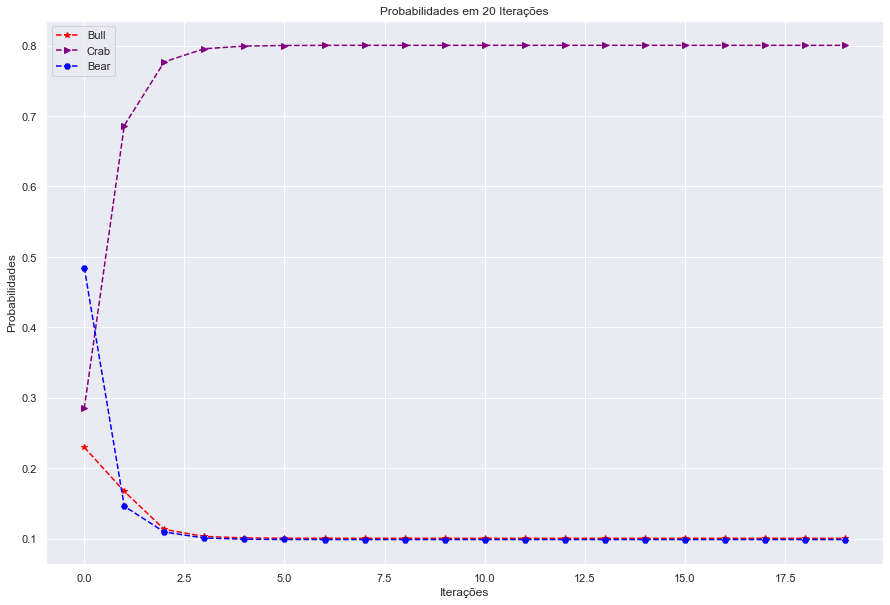

In [7]:
# Gráfico para ilustrar a probabilidade das probabilidades conforme as tentativas

# Calculo dos dados para 20 iterações:
plot_data = []
for step in range(20):
    result = mbg * np.linalg.matrix_power(MP,step)
    plot_data.append(np.array(result).flatten())
    
# Conversão de Formato: 
plot_data = np.array(plot_data)

# Obtenção dos dados por arrays individuais divididos pela Probabiliade:
Bull = plot_data[:, [0]]

Crab = plot_data[:, [1]]

Bear = plot_data[:, [2]]

# Definição do número de tentativas e eixo x do gráfico:
Tentativas = np.arange(0,20,1)

#Plot do gráfico
sns.set()

def plot_temp():
    fig, ax = plt.subplots(figsize=(15,10))
    plt.title("Probabilidades em 20 Iterações")
    plt.xlabel('Iterações')
    plt.ylabel('Probabilidades') 
    ax.plot(Tentativas, Bull, "--*", label = "Bull", color='red')
    ax.plot(Tentativas, Crab, "-->", label = "Crab", color='purple')
    ax.plot(Tentativas, Bear, "--H", label = "Bear", color='blue')
    plt.legend()
    plt.savefig("DistEst.png")

plot_temp()

Tempo Médio de Primeira Passagem

$\mu_{ij} = 1 + \sum_{k \neq j} \mu_{kj} P_{ik}^{m}$

In [8]:
# Tempo Médio de Primeira Passagem
import numpy.linalg as la

#Conversão do formato da Distancia Estacionária:
PiM = np.matrix(Pi)
PiMT = np.transpose(PiM)


# Função Utilizada para o cálculo do Tempo Médio de Primeria Passagem:
def FMTP(F):

    A=np.zeros_like(F) # Matriz nula
    k=PiMT.shape[0]
    for i in range(k):
        A[:,i]=PiMT
    A=A.transpose() # matriz transposta
    Z=la.inv(Matrix_I-F+A) # matriz resultante da operaçao
    D=np.diag(1./np.diag(A))
    Zdg=np.diag(np.diag(Z))
    M=(Matrix_I-Z+Matrix_U*Zdg)*D
    return M

# Tempo Médio de Primeira Passagem:
Mu = FMTP(M_P)
Mu

matrix([[ 9.92140387,  1.54211041, 10.09026306],
        [11.06773299,  1.24968476, 11.28674113],
        [ 9.33234499,  1.61505349, 10.10039727]])

In [9]:
# ARMA #

In [10]:
# Para melhor observação da análise, pegaremos apenas os últimos
# 104 dados, sendo que, 100 serão usados como treino e
# outros 4 para fazer os testes/Predicções.
R_104_Last = R[9976:]

#Normalização 
RN_104_Last = []
for i in range(len(R_104_Last)):
    rnl = (R_104_Last[i] - np.mean(R_104_Last))/(np.std(R_104_Last))
    RN_104_Last.append(rnl)

t = []
i = 0
for i in range(len(RN_104_Last)):
    i += 1 
    t.append(i)
    
Train = RN_104_Last[:100]
Test = RN_104_Last[99:]
t_tr = t[:100]
t_te = t[99:]

Autocovariância:

$\gamma(k) = \frac{1}{1-N} \sum\limits_{i=0}^{N-k} (x_{i+k} - \mu_{x})(x_{i} - \mu_{x})$

In [11]:
# Autocovariância
def AC(x, k):
    AC = 0
    for i in np.arange(0, (len(x)-k)):
        AC += ((x[i+k])-np.average(x))*(x[i]-np.average(x))
    return (1/(len(x)-1))*AC

# Definição do Gamma0 e Gamma1
G0 = AC(Train, 0)
G1 = AC(Train, 1)

$\theta = \sqrt{\gamma_{0} - \frac{\gamma_{1}^2}{\gamma_{1} - 1}}$

$\phi = \frac{\gamma_{0} - 1 - \theta}{\gamma_{1} + \theta}$

ARMA:

$y_{t} = \mu + \phi y_{t-1} + \theta \epsilon_{t-1} + \epsilon_{t}$

In [22]:
theta = np.sqrt(abs(G0 - ((G1**2)/(G0 - 1))))
phi = ((G0 - 1 - theta**2)/(theta + G1))
E = np.random.normal(0, 1, len(RN_104_Last))
Mu = np.mean(Train)

yt = Train[0]
YT = []
for i in range(len(RN_104_Last)):
    YT.append(yt)
    yt = Mu + phi*yt + theta*E[i-1] + E[i]

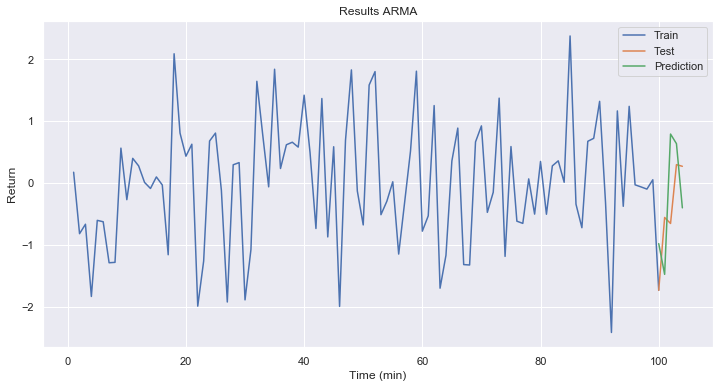

In [23]:
plt.figure(figsize=(12,6))
plt.title('Results ARMA')
plt.xlabel('Time (min)')
plt.ylabel('Return')
plt.plot(t_tr,Train, label = 'Train')
plt.plot(t_te,Test, label = 'Test')
plt.plot(t_te,YT[99:], label = 'Prediction')
plt.legend()

Resíduo (Média Quadrática):

$Resid = \frac{1}{N}\sqrt{\sum\limits_{i=1}^{N} (f_{t} - g{t})^2}$

In [24]:
Residuo = 0
for i in range(len(RN_104_Last)):
    Residuo += (RN_104_Last[i] - YT[i])**2
    residuo = np.sqrt(Residuo/len(RN_104_Last))
print(residuo)

1.5734746790984482


In [ ]:
# GARCH#

In [25]:
from arch import arch_model

g = arch_model(RN, vol = 'GARCH', p=1, q=1, dist="Normal")
g_f = g.fit()
estimation = g_f.forecast()

#print(model_fit.summary())
display(g_f.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12375.444320507839
Iteration:      2,   Func. Count:     17,   Neg. LLF: 12372.140599856837
Iteration:      3,   Func. Count:     27,   Neg. LLF: 12369.930381556196
Iteration:      4,   Func. Count:     36,   Neg. LLF: 12369.671192611913
Iteration:      5,   Func. Count:     43,   Neg. LLF: 12366.910300602949
Iteration:      6,   Func. Count:     50,   Neg. LLF: 12366.391172962058
Iteration:      7,   Func. Count:     58,   Neg. LLF: 12365.903306984725
Iteration:      8,   Func. Count:     64,   Neg. LLF: 12365.80396141256
Iteration:      9,   Func. Count:     70,   Neg. LLF: 12365.78613791793
Iteration:     10,   Func. Count:     76,   Neg. LLF: 12365.785988768614
Iteration:     11,   Func. Count:     82,   Neg. LLF: 12365.785983820631
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12365.785983823062
            Iterations: 11
            Function evaluations: 82
            Gradient eval

C:\Users\erhon\anaconda3\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12365.8
Distribution:                  Normal   AIC:                           24739.6
Method:            Maximum Likelihood   BIC:                           24768.4
                                        No. Observations:                10080
Date:                Thu, Nov 11 2021   Df Residuals:                    10079
Time:                        18:55:17   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.4494e-03  7.814e-03      0.825      0.409 [-8.865e-03,2.176e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0188  7.199e-03      2.604  9.203e-03 [4.640e-03,3.286e-02]
alpha[1]       0.0834  1.697e-02      4.913  8.974e-07   [5.011e-02,  0.117]
beta[1]        0.8977  1.724e-02     52.082      0.000     [  0.864,  0.931]
============================================================================

Covariance estimator: robust
"""

GARCH (1,1) Model:

$\sigma_{t}^2 = \omega + \alpha_{1}r_{t-1}^{2} + \beta_{1}\sigma_{t-1}^2$

In [26]:
G_Vol = 0.1 * np.sqrt(g_f.params['omega'] + g_f.params['alpha[1]'] * g_f.resid**2 
                   + g_f.conditional_volatility**2 * g_f.params['beta[1]'])

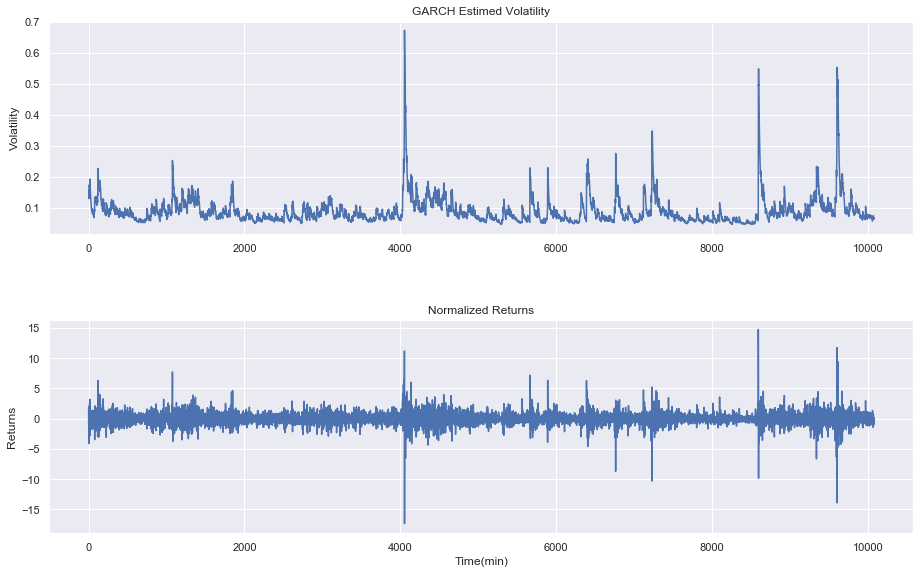

In [28]:
def plot_GARCH_Vol(df):
    fig, axs = plt.subplots(2, figsize=(15,8))
    plt.subplots_adjust(left=0.1, 
                    bottom=0.01,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.xlabel('Time(min)')
    plt.ylabel('Autocorrelation') 
    axs[0].plot(Time,G_Vol, "-")
    axs[0].set_title('GARCH Estimed Volatility')
    axs[0].set_ylabel('Volatility') 
    
    axs[1].plot(Time,RN, "-")
    axs[1].set_title('Normalized Returns')
    axs[1].set_ylabel('Returns')
    axs[1].set_xlabel('Time(min)')
    plt.savefig("Garchh.png")
plot_GARCH_Vol(df)